In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX

from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError

#plt.rcParams['font.family'] = 'AppleGothic'

np.random.seed(42)

In [2]:
df = pd.read_csv('./data/AusAntidiabeticDrug.csv')
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [3]:
df.ds.min(), df.ds.max()

('1991-07-01', '2008-06-01')

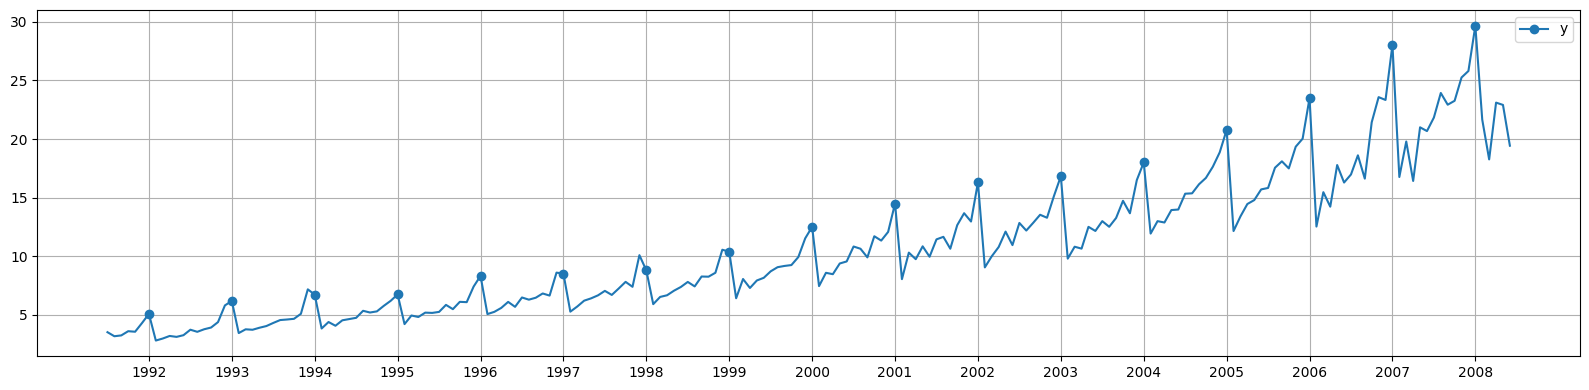

In [4]:
ax = df.plot( markevery=np.arange(6, 203, 12), marker='o', figsize=(16,4))
ax.set_xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
ax.grid()
plt.tight_layout()

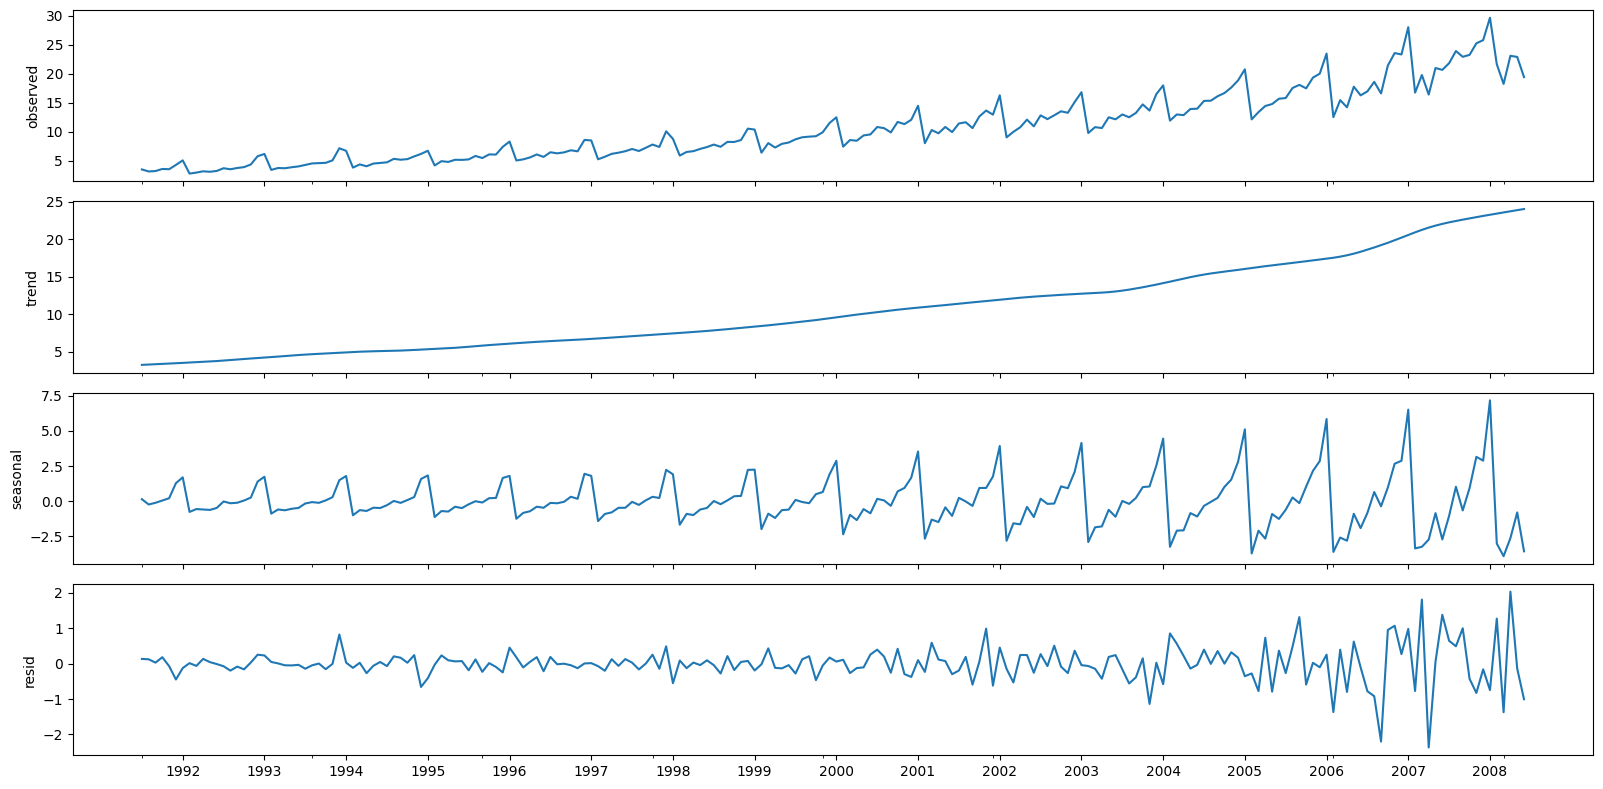

In [5]:
decomposition = STL(df['y'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,8))
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)

ax1.set_ylabel('observed')
ax2.set_ylabel('trend')
ax3.set_ylabel('seasonal')
ax4.set_ylabel('resid')

plt.tight_layout()


In [6]:
df.diff =  df.y.diff()[1:] 
ad_fuller_result = adfuller( df.diff )
ad_fuller_result

(-2.4951721474496953,
 0.1166534168646986,
 15,
 187,
 {'1%': -3.465811691080702,
  '5%': -2.877123351472649,
  '10%': -2.5750770662586864},
 547.1880809726357)

In [7]:
d = 12
df_diff = np.diff(df.diff, n=d)
ad_fuller_result = adfuller(df_diff)
ad_fuller_result

(-19.848440095484218,
 0.0,
 15,
 175,
 {'1%': -3.4682803641749267,
  '5%': -2.8782017240816327,
  '10%': -2.5756525795918366},
 1526.2892092883944)

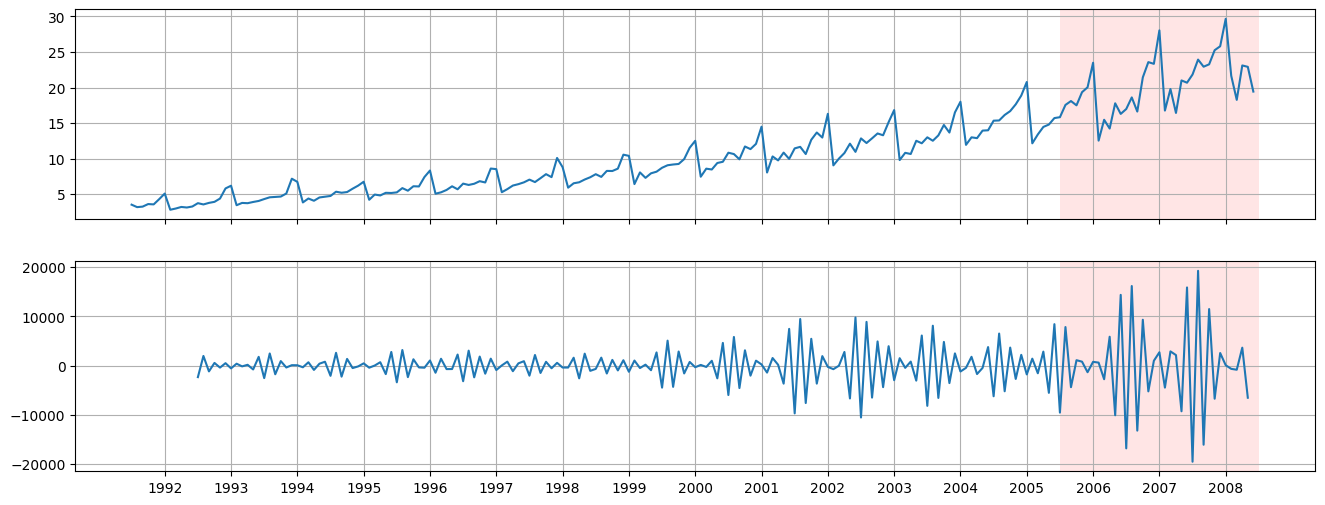

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.plot(df.y )
ax1.axvspan(168, 204, facecolor='red', alpha=0.1)
ax1.set_xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
ax1.grid()

a = pd.DataFrame(df_diff)
a.index = a.index + d
ax2.plot(a)
ax2.axvspan(168, 204, facecolor='red', alpha=0.1)

ax2.grid()
plt.show()

In [9]:
def optimize_SARIMAX(endog: Union[pd.Series, list], order_list: list, d: int, isSeasonal: bool, D = 0, s = 0) -> pd.DataFrame:
    
    results = []

    
    for order in tqdm_notebook(order_list):
        if(isSeasonal == True):
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue
        else:
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]), 
                    simple_differencing=False).fit(disp=False)
            except:
                continue
            
        aic = model.aic
        results.append([order, aic])



    
    result_df = pd.DataFrame(results)
    
    result_df.columns = ['(p,q,P,Q)', 'AIC'] if isSeasonal else ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

train = df.y[:-36]

SARIMAX_result_df = optimize_SARIMAX(train, order_list, d, True, D, s)
SARIMAX_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.218586
2,"(3, 3, 1, 3)",271.463835
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.221736
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


In [11]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Tue, 20 Aug 2024   AIC                            270.951
Time:                                            11:15:50   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

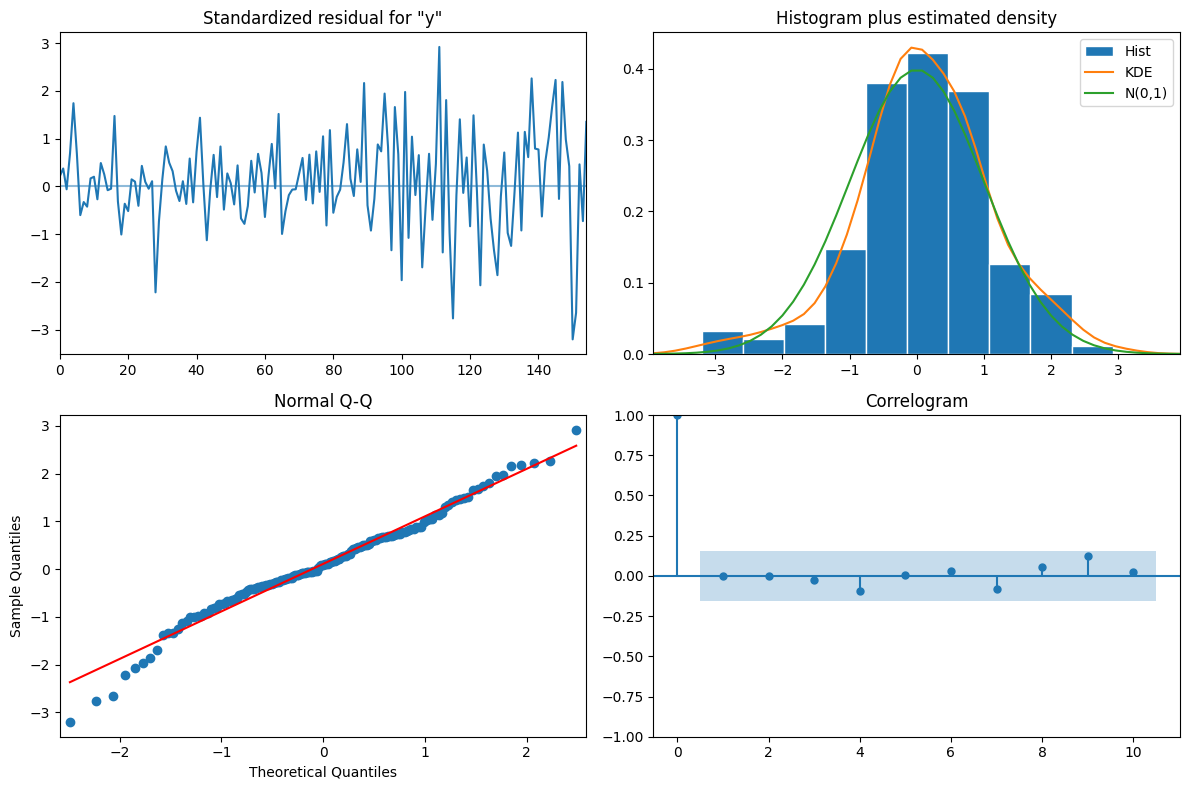

In [12]:
SARIMA_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()

In [13]:
residuals = SARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

      lb_stat  lb_pvalue
1    0.436721   0.508710
2    0.627481   0.730709
3    0.645983   0.885830
4    2.258291   0.688373
5    2.950507   0.707616
6    3.389448   0.758615
7    9.982057   0.189593
8   10.592038   0.225903
9   11.854174   0.221656
10  11.985487   0.286029


In [29]:
df.y[-48:-12].values

array([15.33909742, 15.37076394, 16.142005  , 16.685754  , 17.636728  ,
       18.869325  , 20.778723  , 12.154552  , 13.402392  , 14.459239  ,
       14.795102  , 15.705248  , 15.82955   , 17.554701  , 18.100864  ,
       17.496668  , 19.347265  , 20.031291  , 23.486694  , 12.536987  ,
       15.467018  , 14.233539  , 17.783058  , 16.291602  , 16.980282  ,
       18.612189  , 16.623343  , 21.430241  , 23.575517  , 23.334206  ,
       28.038383  , 16.763869  , 19.792754  , 16.427305  , 21.000742  ,
       20.681002  ])

In [31]:
pred_df = df[-36:]
pred_df['naive_seasonal'] =  df.y[-48:-12].values
pred_df['SARIMA_pred'] = SARIMA_model_fit.get_prediction(168, 204).predicted_mean
pred_df

,ds,y,naive_seasonal,SARIMA_pred
168,2005-07-01,15.829550,15.339097,16.745824
169,2005-08-01,17.554701,15.370764,16.619349
170,2005-09-01,18.100864,16.142005,17.255322
171,2005-10-01,17.496668,16.685754,18.107510
172,2005-11-01,19.347265,17.636728,18.722212
173,2005-12-01,20.031291,18.869325,19.885865
174,2006-01-01,23.486694,20.778723,22.216381
175,2006-02-01,12.536987,12.154552,13.544402
176,2006-03-01,15.467018,13.402392,14.972385
177,2006-04-01,14.233539,14.459239,15.593463


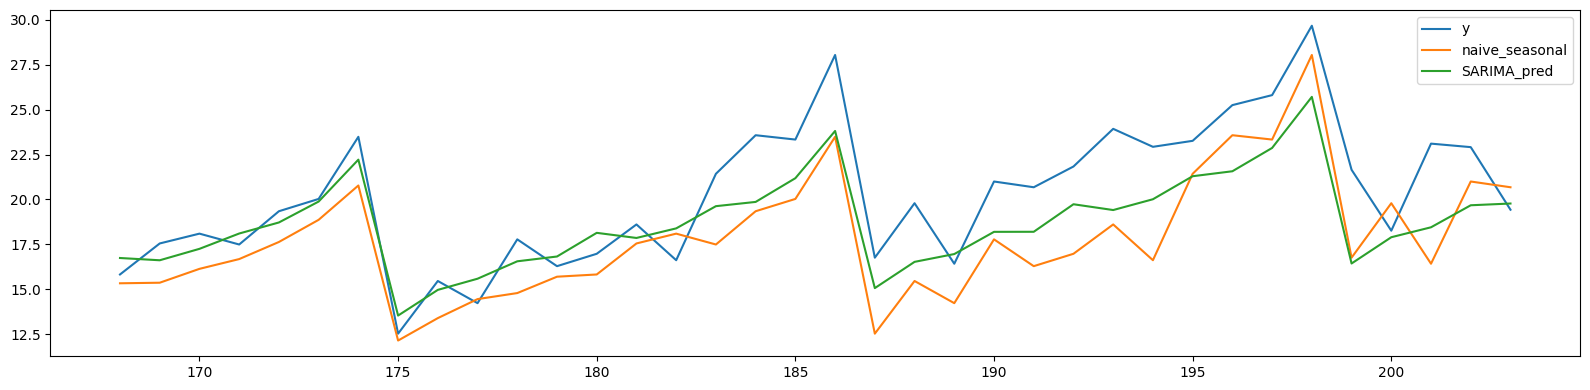

In [34]:
pred_df.plot( figsize=(16,4))
plt.tight_layout()

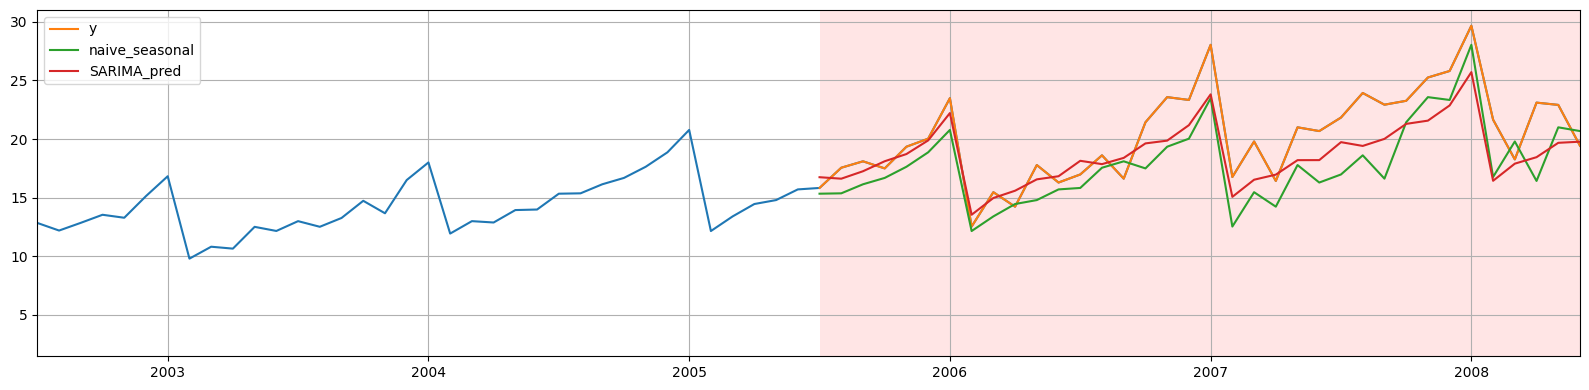

In [35]:
ax = df.y.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(168, 204, facecolor='red', alpha=0.1)
ax.set_xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
ax.set_xlim(132, 203)
pred_df.plot( ax = ax)
ax.grid()
plt.tight_layout()

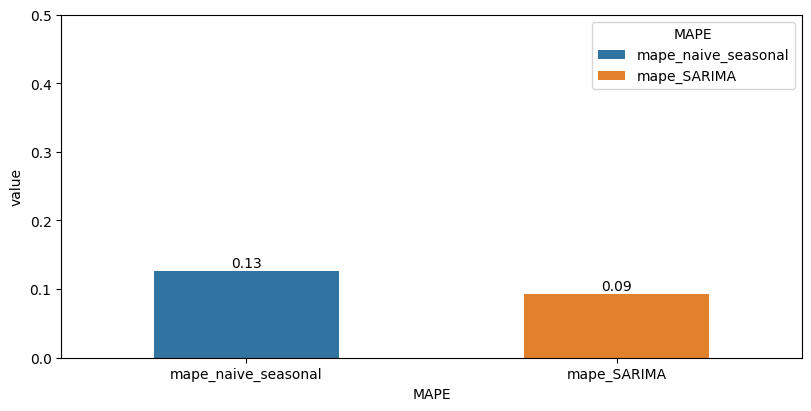

In [37]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_naive_seasonal = torch.FloatTensor( pred_df['naive_seasonal'].values)
predict_SARIMA = torch.FloatTensor( pred_df['SARIMA_pred'].values)
target = torch.FloatTensor(pred_df['y'].values)

mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_naive_seasonal, target).item()
mapes['mape_SARIMA'] = mean_abs_percentage_error( predict_SARIMA, target ).item()


fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.5)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

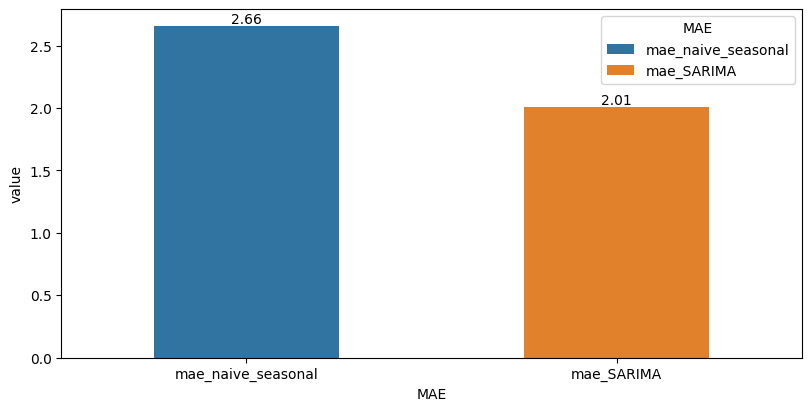

In [36]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_naive_seasonal = torch.FloatTensor( pred_df['naive_seasonal'].values)
predict_SARIMA = torch.FloatTensor( pred_df['SARIMA_pred'].values)
target = torch.FloatTensor(pred_df['y'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_naive_seasonal, target ).item()
maes['mae_SARIMA'] = mean_absolute_error( predict_SARIMA, target ).item()

fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [39]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [40]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df2 = df[168:]
pred_df2['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_df2['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_df2

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.745824
169,2005-08-01,17.554701,15.370764,16.619349
170,2005-09-01,18.100864,16.142005,17.255322
171,2005-10-01,17.496668,16.685754,18.107510
172,2005-11-01,19.347265,17.636728,18.722212
173,2005-12-01,20.031291,18.869325,19.885865
174,2006-01-01,23.486694,20.778723,22.216381
175,2006-02-01,12.536987,12.154552,13.544402
176,2006-03-01,15.467018,13.402392,14.972385
177,2006-04-01,14.233539,14.459239,15.593463


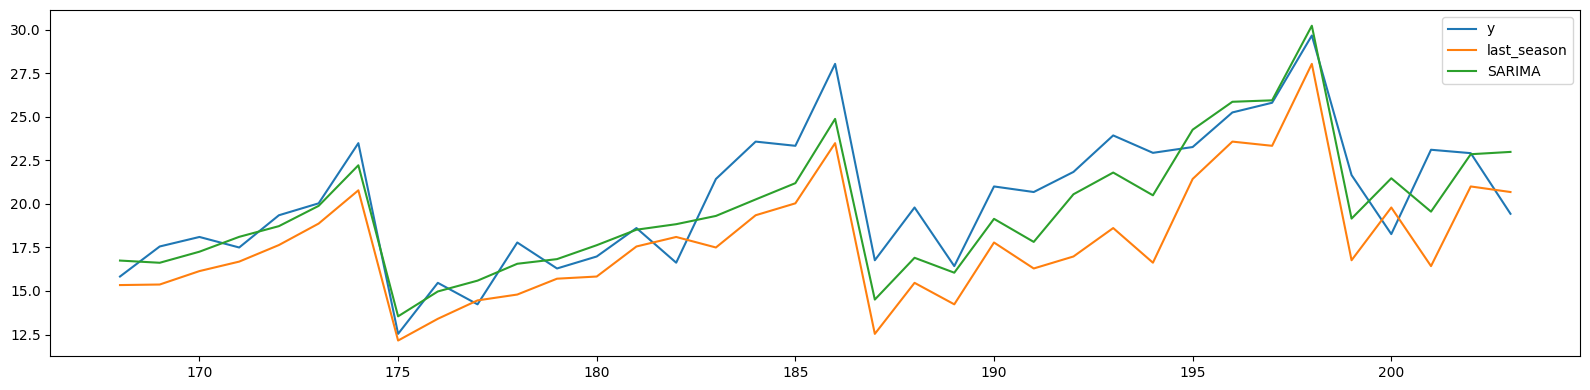

In [41]:
pred_df2.plot( figsize=(16,4))
plt.tight_layout()

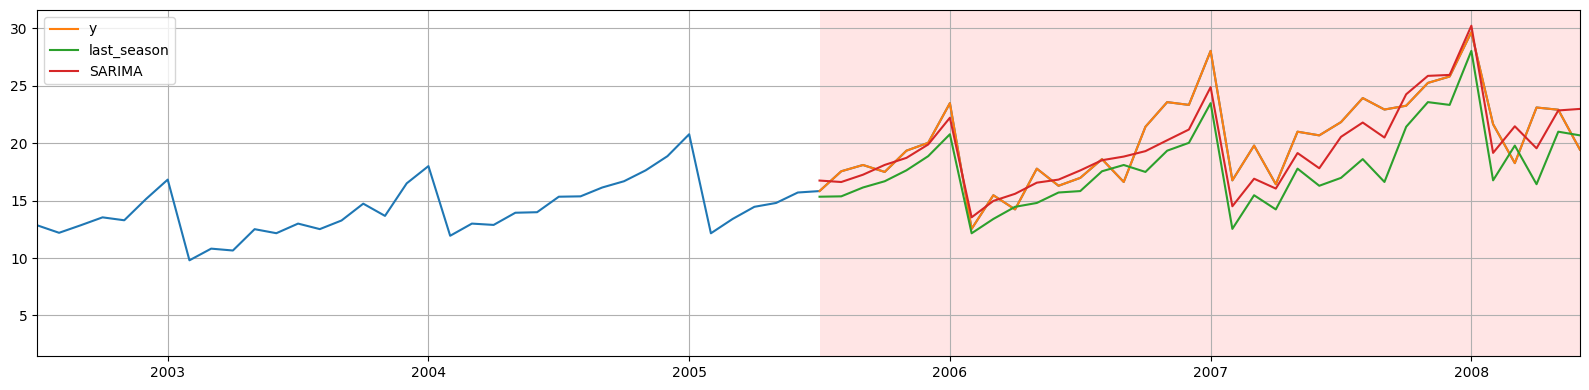

In [42]:
ax = df.y.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(168, 204, facecolor='red', alpha=0.1)
ax.set_xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
ax.set_xlim(132, 203)
pred_df2.plot( ax = ax)
ax.grid()
plt.tight_layout()

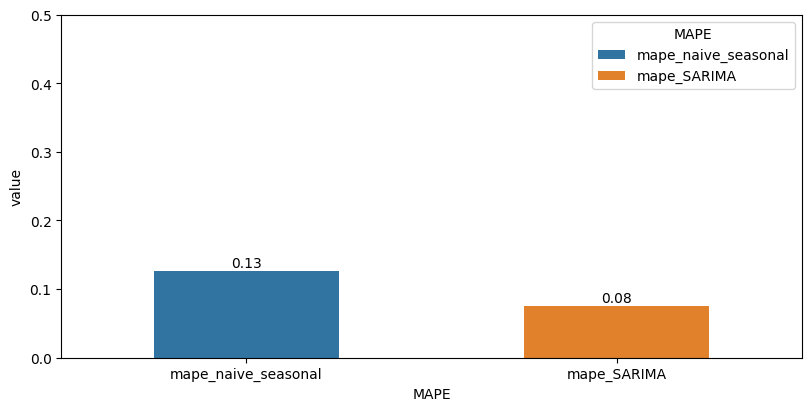

In [44]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_naive_seasonal = torch.FloatTensor( pred_df2['last_season'].values)
predict_SARIMA = torch.FloatTensor( pred_df2['SARIMA'].values)
target = torch.FloatTensor(pred_df2['y'].values)

mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_naive_seasonal, target).item()
mapes['mape_SARIMA'] = mean_abs_percentage_error( predict_SARIMA, target ).item()


fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.5)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

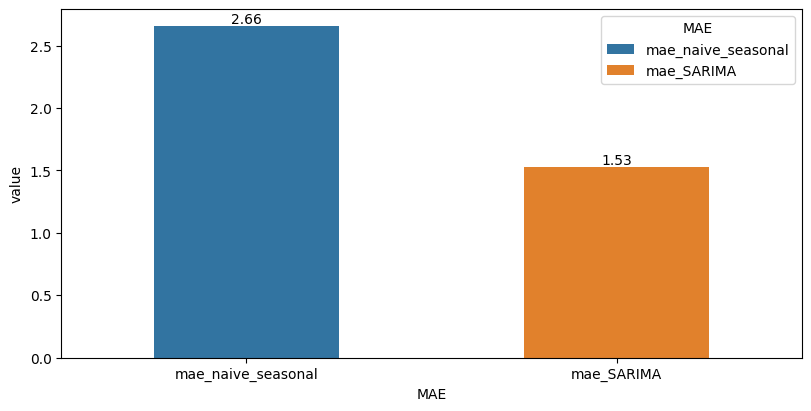

In [45]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_naive_seasonal = torch.FloatTensor( pred_df2['last_season'].values)
predict_SARIMA = torch.FloatTensor( pred_df2['SARIMA'].values)
target = torch.FloatTensor(pred_df2['y'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_naive_seasonal, target ).item()
maes['mae_SARIMA'] = mean_absolute_error( predict_SARIMA, target ).item()

fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)